# Lesson 6 - Global Warning Sentiment Classifier

In [163]:
import numpy as np
from functools import partial
import pandas as pd

import torchtext
import torch
from torch import nn
from torch.nn import functional as F
import spacy
import fastai.nlp
from fastai.learner import fit
from fastai.core import V
from fastai.metrics import accuracy
from fastai.lm_rnn import seq2seq_reg, repackage_var
from fastai.nlp import RNN_Learner
from IPython.display import display

from pathlib import Path

In [112]:
df = pd.read_csv('./data/global_warming_tweets.csv', encoding='latin1')

Drop all Tweets that aren't about global warming:

In [113]:
df.existence.value_counts()

Y      2554
N      1053
Yes     557
No       61
Name: existence, dtype: int64

In [114]:
df = df.dropna()

In [115]:
df.existence = df.existence.replace({'Yes': 'Y', 'No': 'N'})

In [116]:
df.existence.value_counts(dropna=False)

Y    3111
N    1114
Name: existence, dtype: int64

In [117]:
df = df.sample(frac=1, random_state=42)

In [118]:
train_df = df[:-1000]
val_df = df[-1000:]

In [119]:
train_df.shape

(3225, 3)

In [120]:
val_df.shape

(1000, 3)

In [121]:
train_df.existence.value_counts()

Y    2384
N     841
Name: existence, dtype: int64

In [122]:
val_df.existence.value_counts()

Y    727
N    273
Name: existence, dtype: int64

## Torchtext basics

I'll start with a very simple classifier that uses just one RNN layer. I won't even use a learner object for this and only the `fit` Fast.ai function.

The `data.Field` Torchtext classes describe how to process a set of text. In this example, we intend to lowercase each string:

`HELLO` -> `hello`

and tokenise it with Spacy.

In [123]:
nlp = spacy.load('en')

In [124]:
train_df.iloc[10].tweet

'Microbes Contribute Less to Global Warming|New Haven, Conn. .. http://oohja.com/xbNVU'

In [125]:
tokens = nlp(train_df.iloc[0].tweet)

In [126]:
[t for t in tokens]

[Putting,
 a,
 Price,
 on,
 Climate,
 Change,
 :,
 The,
 People,
 's,
 World,
 Conference,
 on,
 Climate,
 Change,
 in,
 Cochabamba,
 ,,
 Bolivia,
 kicks,
 ...,
 http://bit.ly/8XnI5N,
 #,
 p2]

In [127]:
TEXT_FIELD = torchtext.data.Field(lower=True, tokenize="spacy")
# Tokenisation is not applied when `sequential=False`.
LABEL_FIELD = torchtext.data.Field(sequential=False)

We'll also need a Dataset. Which in Torch text is an object that stores a list of `examples` which includes the text, it's label and the `Field` used to process it.

In [128]:
class DataFrameDataset(torchtext.data.Dataset):

    def __init__(self, df, text_field, label_field, is_test=False, **kwargs):
        fields = [('text', text_field), ('label', label_field)]
        examples = []
        for i, row in df.iterrows():
            label = row.existence if not is_test else None
            text = row.tweet
            examples.append(torchtext.data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    @classmethod
    def splits(cls, text_field, label_field, train_df, val_df=None, test_df=None, **kwargs):
        train_data, val_data, test_data = (None, None, None)

        if train_df is not None:
            train_data = cls(train_df.copy(), text_field, label_field, **kwargs)
        if val_df is not None:
            val_data = cls(val_df.copy(), text_field, label_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), text_field, label_field, True, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)

`splits` refers to the train, val and test split and is a big part of the Torchtext lingo. Here's how you would construct split:

In [129]:
train_ds, val_ds, test_ds = DataFrameDataset.splits(
  text_field=TEXT_FIELD, label_field=LABEL_FIELD, train_df=train_df, val_df=val_df, test_df=val_df)

We can now prepare our `TEXT_FIELD` by building the vocab on it, which simply maps tokens to ints:

In [130]:
TEXT_FIELD.vocab

AttributeError: 'Field' object has no attribute 'vocab'

In [132]:
TEXT_FIELD.build_vocab(train_ds)

In [133]:
TEXT_FIELD.vocab

In [134]:
TEXT_FIELD.vocab.stoi['globalwarming']

344

In [136]:
TEXT_FIELD.vocab.itos[344]

'globalwarming'

In [137]:
LABEL_FIELD.build_vocab(train_df)

In PyTorch, a dataset is very much like a list: it can be iterated through and we can also fetch individual items by id:

In [138]:
train_ds[100].text

['boy', '.', 'global', 'warming', 'is', 'one', 'slick', 'buster', '.']

In [139]:
next(iter(train_ds)).text

['putting',
 'a',
 'price',
 'on',
 'climate',
 'change',
 ':',
 'the',
 'people',
 "'s",
 'world',
 'conference',
 'on',
 'climate',
 'change',
 'in',
 'cochabamba',
 ',',
 'bolivia',
 'kicks',
 '...',
 'http://bit.ly/8xni5n',
 '#',
 'p2']

What we want is a tool to batch our examples up for us. Since an RNN is a sequence model, which can support variable length sequences (lists of data), what we want is a batching strategy that will let us train on multiple sentences at a time but still let us use a for loop over them. Torchtext solves the problem like this:

```
First element   |  Second element   |
['rt']          |  ['the']
['global']      |  ['warming']
['Hello']       |  ['world']
```

So the first element is 64x1, which is the first word in 64 different sequences and so on.

Torchtext provides a "bucket iterator" which handles batching. In Torchtext, they call these iterators what Torchvision called data loaders (no idea why that is).

Let's create an iterator for each split:

In [56]:
train_iter, val_iter, test_iter = torchtext.data.BucketIterator.splits(
    (train_ds, val_ds, test_ds), batch_sizes=(16, 256, 256), sort_key=lambda x: len(x.text))

In [57]:
train_batch = next(iter(train_iter))

In [58]:
train_batch.text.shape

torch.Size([27, 16])

What we have is a sentence length of 34, with a batch size of 16.

In [59]:
train_batch = next(iter(train_iter))

In [60]:
train_batch.text.shape

torch.Size([28, 16])

Notice how the sequence length changes each time? An RNN can handle that just fine.

Fast.AI provides a convenience wrapper around all this called `fastai.nlp.TextData`. Let's use that and make sure it appears to work the same:

In [140]:
PATH = Path('./data/global-sentiment')
PATH.mkdir(exist_ok=True)

In [141]:
bs = 16

In [142]:
text_data = fastai.nlp.TextData.from_splits(PATH, (train_ds, val_ds, test_ds), bs=bs, text_name='text', label_name='label')

In [63]:
train_batch, y = next(iter(text_data.trn_dl))

In [65]:
text_data.trn_dl.src

In [66]:
train_batch.shape

torch.Size([27, 16])

In [67]:
train_batch, y = next(iter(text_data.trn_dl))

In [68]:
train_batch.shape

torch.Size([28, 16])

## Simple RNN classifier

It's the same. Okay, so now we understand `TextData`, let's build a simple RNN model. I will use a for loop initially, instead of using the `nn.RNN` class.

In [70]:
class RNNClassifier(torch.nn.Module):
    def __init__(self, embedding_dim, hidden_size, vocab_size):
        super().__init__()
        
        self.hidden_size = hidden_size
        
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.input_layer = torch.nn.Linear(embedding_dim + hidden_size, hidden_size)
        self.hidden_layer = torch.nn.Linear(hidden_size, hidden_size)
        self.output_layer = torch.nn.Linear(hidden_size, vocab_size)
        
    def forward(self, words):
        batch_size = words[0].size(0)
        
        hidden = V(torch.zeros(batch_size, self.hidden_size))
        
        for word in words:
            e = self.embedding(word)
            concat = torch.cat([hidden, e], dim=1)
            inp = self.input_layer(concat)
            inp = torch.nn.functional.relu(inp)

            hidden = torch.nn.functional.tanh(self.hidden_layer(inp))
            
        return torch.nn.functional.log_softmax(self.output_layer(hidden), dim=-1)

In [73]:
emb_size = 200
hidden_size = 256
vocab_size = len(TEXT_FIELD.vocab.stoi)

model = RNNClassifier(emb_size, hidden_size, vocab_size)
opt = torch.optim.Adam(model.parameters(), 1e-3)

In [74]:
learner = RNN_Learner.from_model_data(model, text_data)

In [75]:
learner.lr_find()

 81%|████████  | 138/171 [00:13<00:03, 10.05it/s, loss=9.56]

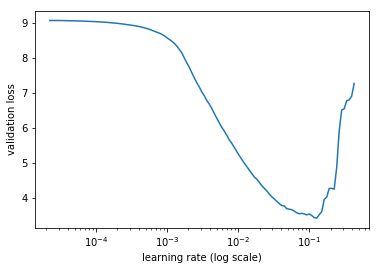

In [76]:
learner.sched.plot()

In [77]:
learner.fit(0.02, 1, metrics=[accuracy])

epoch      trn_loss   val_loss   accuracy                   
    0      1.451926   1.974098   0.295513  


[array([1.9741]), 0.29551334422657954]

In [78]:
learner.fit(0.02, 3, metrics=[accuracy], cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.990833   0.745997   0.713712  
    1      0.993644   0.84675    0.663501                    
    2      0.977493   0.608515   0.701355                    
    3      0.648026   0.734888   0.482503                    
    4      0.607096   0.62423    0.70384                     
    5      0.591332   0.612563   0.697644                    
    6      0.569476   0.749776   0.524612                    


[array([0.74978]), 0.5246119281045751]

Results are not amazing. We know that loosing the hidden state in between forward passes is not ideal. Can we try the stateful RNN model.

In [86]:
class StatefulRNNClassifier(nn.Module):
    def __init__(self, vocab_size, n_fac, n_hidden, batch_size):
        self.vocab_size = vocab_size
        self.n_hidden = n_hidden

        super().__init__()
    
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.RNN(n_fac, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(batch_size)
        
    def forward(self, cs):
        batch_size = cs[0].size(0)

        if self.h.size(1) != batch_size:
            self.init_hidden(batch_size)

        outp, h = self.rnn(self.e(cs), self.h)

        self.h = repackage_var(h)

        return F.log_softmax(
            self.l_out(outp[-1]), dim=-1).view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.h = V(torch.zeros(1, bs, self.n_hidden))

In [87]:
rank_3_tensor = V(torch.zeros(1, 16, 256))

In [88]:
rank_3_tensor.shape

torch.Size([1, 16, 256])

In [89]:
rank_3_tensor.view(-1, 256).shape

torch.Size([16, 256])

In [90]:
emb_size = 200
hidden_size = 256
vocab_size = len(TEXT_FIELD.vocab.stoi)

model = StatefulRNNClassifier(vocab_size, emb_size, hidden_size, 16)
opt = torch.optim.Adam(model.parameters(), 1e-3)

In [91]:
learner = RNN_Learner.from_model_data(model, text_data)

In [92]:
learner.model.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.model.clip = 25.

In [93]:
learner.unfreeze()

In [94]:
learner.lr_find()

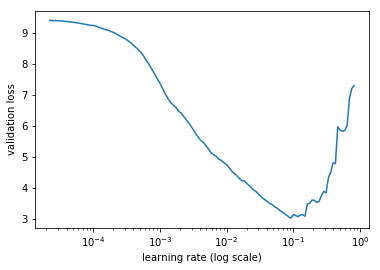

In [95]:
learner.sched.plot()

In [96]:
learner.fit(0.02, 1, metrics=[accuracy])

epoch      trn_loss   val_loss   accuracy                    
    0      0.911752   0.767767   0.47835   


[array([0.76777]), 0.4783496732026144]

In [97]:
learner.fit(0.02, 3, metrics=[accuracy], cycle_mult=3)

epoch      trn_loss   val_loss   accuracy                    
    0      0.748554   1.019432   0.306781  
    1      0.839878   0.935877   0.531148                    
    2      0.847822   0.732368   0.627519                    
    3      0.681256   0.808527   0.565325                    
    4      0.778132   1.7248     0.337963                    
    5      0.688554   0.827571   0.66282                     
    6      0.623782   0.872698   0.608762                    
    7      0.627264   1.113532   0.635417                    
    8      0.648929   0.981717   0.608898                    
    9      0.597645   1.030251   0.620064                    
    10     0.611026   1.184489   0.624081                    
    11     0.633573   1.076439   0.668777                    
    12     0.744565   1.113526   0.648148                    


[array([1.11353]), 0.6481481481481481]

## Swap out the RNN for an LSTM

An LSTM does a better job at keeping track at longer term dependancies. For example:

"The dog which already walked ... *was* tired"

"The dogs which already walked ... *were* tired"

A standard RNN tends to 

In [100]:
class StatefulLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, n_fac, n_hidden, batch_size, nl):
        self.nl = nl
        self.vocab_size = vocab_size
        self.n_hidden = n_hidden
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.LSTM(n_fac, n_hidden, self.nl)
        self.l_out = nn.Linear(n_hidden, vocab_size, 2)
        self.init_hidden(batch_size)
        
    def forward(self, cs):
        batch_size = cs[0].size(0)
        if self.h[0].size(1) != batch_size:
            self.init_hidden(batch_size)

        outp, h = self.rnn(self.e(cs), self.h)
        self.h = repackage_var(h)
        return F.log_softmax(self.l_out(outp[-1]), dim=-1).view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.h = (V(torch.zeros(self.nl, bs, self.n_hidden)),
                  V(torch.zeros(self.nl, bs, self.n_hidden)))

In [101]:
emb_size = 200
hidden_size = 256
vocab_size = len(TEXT_FIELD.vocab.stoi)

model = StatefulLSTMClassifier(vocab_size, emb_size, hidden_size, 16, 2)
opt = torch.optim.Adam(model.parameters(), 1e-3)

In [102]:
learner = RNN_Learner.from_model_data(model, text_data)

In [103]:
learner.unfreeze()

In [104]:
learner.lr_find()

epoch      trn_loss   val_loss                              
    0      2.450264   4.111816  


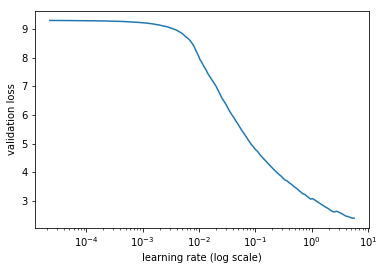

In [105]:
learner.sched.plot()

In [339]:
learner.fit(0.1, 3, metrics=[accuracy], cycle_mult=3)

epoch      trn_loss   val_loss   accuracy                    
    0      0.642714   0.664135   0.704802  
    1      0.590536   0.958193   0.293584                    
    2      0.587968   0.612797   0.703138                    
    3      0.579308   0.803199   0.464033                    
    4      0.557207   0.715474   0.60679                     
    5      0.535623   0.637085   0.653148                    
    6      0.503278   0.558036   0.720642                    
    7      0.464245   0.554885   0.728965                    
    8      0.45296    0.534932   0.744149                    
    9      0.45852    0.532461   0.717514                    
    10     0.407448   0.551546   0.754843                    
    11     0.437047   0.818363   0.615365                    
    12     0.393547   0.673225   0.735472                    


[array([0.67323]), 0.7354721549636803]

In [340]:
learner.fit(0.1, 3, metrics=[accuracy], cycle_mult=3)

epoch      trn_loss   val_loss   accuracy                    
    0      0.336083   0.588867   0.765234  
    1      0.299134   0.682336   0.766646                    
    2      0.274451   0.688969   0.772296                    
    3      0.237138   0.760314   0.768261                    
    4      0.2239     0.69131    0.786168                    
    5      0.165534   0.848869   0.774617                    
    6      0.140051   0.887794   0.748234                     
    7      0.123986   0.858684   0.769471                     
    8      0.121634   0.877789   0.777038                     
    9      0.111991   0.986204   0.774314                     
    10     0.089316   1.019616   0.772952                     
    11     0.066097   1.050458   0.782536                     
    12     0.059231   1.125723   0.752522                     


[array([1.12572]), 0.7525221953188055]

## Use the Fast.ai RNN classifier

The TextData has it's own model, let's try that.

In [143]:
bs = 64
bptt = 70
em_sz = 200
nh = 500
nl = 3

In [144]:
opt_fn = partial(torch.optim.Adam, betas=(0.7, 0.99))
learner = text_data.get_model(
    opt_fn, 1500, bptt, emb_sz=em_sz, n_hid=nh, n_layers=nl, 
    dropout=0.1, dropouti=0.4, wdrop=0.5, dropoute=0.05, dropouth=0.3)

In [145]:
learner

SequentialRNN(
  (0): MultiBatchRNN(
    (encoder): Embedding(9065, 200, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(9065, 200, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(200, 500)
      )
      (1): WeightDrop(
        (module): LSTM(500, 500)
      )
      (2): WeightDrop(
        (module): LSTM(500, 200)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): ModuleList(
      (0): LinearBlock(
        (lin): Linear(in_features=600, out_features=3, bias=True)
        (drop): Dropout(p=0.1)
        (bn): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True)
      )
    )
  )
)

In [146]:
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip = 0.3

In [147]:
learner.fit(3e-3, 4, wds=1e-6, cycle_len=1, cycle_mult=2, metrics=[accuracy])

epoch      trn_loss   val_loss   accuracy                    
    0      0.473344   0.461434   0.776937  
    1      0.393316   0.511505   0.776079                    
    2      0.222065   0.460314   0.804782                    
    3      0.301563   0.464333   0.792474                    
    4      0.222063   0.600617   0.807254                    
    5      0.110187   0.698418   0.80231                     
    6      0.079147   0.717064   0.798073                     
    7      0.218971   0.778986   0.793886                    
    8      0.163321   0.707321   0.801907                    
    9      0.144864   0.77834    0.794794                    
    10     0.102619   0.725458   0.801755                     
    11     0.075765   0.777664   0.795046                     
    12     0.046675   0.905923   0.7841                       
    13     0.041044   0.885935   0.802159                     
    14     0.028916   0.875052   0.800192                     


[array([0.87505]), 0.8001916868442293]

In [148]:
learner.save_encoder('enc1')

In [ ]:
learner.save('model_adam1')

## Viewing val predictions

In [200]:
pd.set_option('display.max_colwidth', -1)

In [192]:
probs = learner.predict()
preds = np.argmax(probs, axis=1)
pred_labels = [LABEL_FIELD.vocab.itos[p] for p in preds]

val_results = val_df.copy()
val_results['pred'] = pred_labels
val_results['prob'] = np.exp(np.max(probs, axis=1))

### View correct results

In [201]:
val_results[val_results['pred'] == val_results['existence']][['tweet', 'existence', 'pred']].head()

,tweet,existence,pred
4080,"@conoverbeth I think the report is valuable in terms of visible, observable climate change impacts in the US right now (but no invlvmnt)",Y,Y
5494,"Is this the end of migration? - Climate Change, Environment - The Independent http://retwt.me/1MShX (via @terriferic)",Y,Y
1952,"Only a Third of Americans Believe Global Warming is Human-Caused: By Bob Ellis on April 26th, 2010 Good news! What... http://bit.ly/9XGqPB",N,N
1096,Climate change & sustainability will be a key driver of future economic development. Listen at http://bit.ly/9Uytgl,Y,Y
3150,Snowstorm: E Coast Blizzard Tied to Climate Change - @TIME http://bit.ly/9TRnGU,Y,Y


### Incorrect results

In [202]:
val_results[val_results['pred'] != val_results['existence']][['tweet', 'existence', 'pred']].head()

,tweet,existence,pred
5548,Houston Chronicle: 'The heat goes on: After a blitz by climate change skep.. http://retwt.me/1MQpP (via @climateprogress),Y,N
1978,Brochure on Global Warming 1992: Brochure on Global Warming 1992 added by: neham 0 comments http://bit.ly/bbxgVF,Y,N
4189,"Global Warming In One State: Like clockwork, whenever there is any kind of change in the natural landscape here in... http://bit.ly/bk1xyA",Y,N
403,SEC warns publically held companies to advise investors of risks of #climate change. [link],Y,N
64,@SooperMexican Global warming. Clearly.,Y,N


### Most confident wrong predictions

In [198]:
val_results[val_results['pred'] != val_results['existence']].sort_values('prob', ascending=False)[['tweet', 'existence', 'pred']].head()

,tweet,existence,pred
3071,EU Referendum: British Council spends _£3.5 million on climate change propaganda http://retwt.me/1LSjS (via @afashionfan),N,Y
3863,RT @BillWilsonALG: Lindsay Graham getting public love from Obama. Someone needs to tell Graham that climate change is a proven lie. http://bit.ly/9w8RHw #tcot,N,Y
3710,The Great Global Warming Collapse http://bit.ly/9VeLfD,N,Y
3368,RT @owillis: RT @mmfa Brain Freeze: Conservative media still using winter weather 2 attack global warming http://bit.ly/9nKEcc #p2,N,Y
5955,"Global warming? Well, not exactly. As if we could tell anyway: OCRegister (blog) What a hoot when global warming a... http://bit.ly/9PKvc3",N,Y


### Most confident right predictions

In [199]:
val_results[val_results['pred'] == val_results['existence']].sort_values('prob', ascending=False)[['tweet', 'existence', 'pred']].head()

,tweet,existence,pred
2098,"RT @charles_baker 3,000 Businesses Create New Ad for Climate Change Action: http://bit.ly/cADHuR (via @FaisalSethi + @DoGoodHQ)",Y,Y
5703,"Gregory Unruh: Oven Dial or Light Switch: Carbon Lock-in and Abrupt Climate Change: Well over a decade ago, I bec... http://huff.to/auGUFY",Y,Y
1237,"RT @hereisawayjose Bolivia President on Global Warming http://su.pr/2YY1Lc ""Main cause of Earth destruction is capitalism"" #Green #EarthDay",Y,Y
4042,. http://bit.ly/aqwt24 global warming facts World leaders back embattled Pachauri,Y,Y
5753,"Global warming? Great!: ""The threat from climate change is serious, it is urgent, and it is growing,"" President Ob... http://bit.ly/a3FWD0",Y,Y


## Making test predictions

In [151]:
learner.data.test_dl.src.sort = False
learner.data.test_dl.src.sort_within_batch = False
learner.data.test_dl.src.shuffle = False

In [153]:
probs = learner.predict(is_test=True)
preds = np.argmax(probs, axis=1)

In [205]:
pd.DataFrame({
    'id': val_df.index,
    'sentiment': [LABEL_FIELD.vocab.itos[p] for p in preds]}).head(10)

,id,sentiment
0,4080,Y
1,5494,Y
2,1952,N
3,5548,N
4,1096,Y
5,3150,Y
6,1978,N
7,4189,N
8,1544,Y
9,403,N
